# Imports

In [1]:
import os
import torchvision
from torchvision import models,transforms,datasets
import torch.nn as nn
import time

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
import bcolz
%matplotlib inline

In [ ]:
!pip install bcolz

In [2]:
import imp
import utils; imp.reload(utils)
from utils import *

GPU test

In [3]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [ ]:
use_gpu =  False

# Data process

In [4]:
# data_dir = 'D:\\Tu Beo\\Education\\FoodVisor\\data\\UPMC_Food101\\images'
data_dir = '/home/foodlovers/FoodVisor/data/images'
# data_dir = "/home/foodlovers/FoodVisor/FoodVisor-TMM/data/UPMC_2"

In [5]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep2)
         for x in ['train', 'test']}

In [ ]:
len(dsets['train'].classes)

In [ ]:
dsets['train'].class_to_idx

In [ ]:
dsets['train'].imgs[:5]

In [8]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 67988, 'test': 22716}

Dataset loaders

In [6]:
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=shuffle_valtrain(x), num_workers=6)
                for x in ['train', 'test']}

In [ ]:
len(dset_loaders['train'])

In [ ]:
dataset_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=True, num_workers=6)

In [ ]:
len(dataset_valid)

In [ ]:
count = 0
for data in dataset_valid:
    if count == 0:
        inputs_try,labels_try = data
    else:
        break
    count += 1

In [ ]:
labels_try

In [ ]:
inputs_try.shape

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [ ]:
# Get a batch of validation data
inputs, classes = next(iter(dset_loaders['test']))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

# Creating InceptionV3 Model

In [7]:
model_inception = models.inception_v3(pretrained=True)

In [ ]:
if use_gpu:
    model_inception = model_inception.cuda()
    
inputs_try , labels_try = var_cgpu(inputs_try,use_gpu),var_cgpu(labels_try,use_gpu)

In [ ]:
outputs_try,__ = model_inception(inputs_try)

In [ ]:
inputs_try.shape

In [ ]:
outputs_try

In [ ]:
outputs_try.shape

### Modifying the last layer and setting the gradient false to all layers

In [ ]:
print(model_inception)

In [ ]:
for param in model_inception.parameters():
    param.requires_grad = False

In [9]:
model_inception.fc = nn.Linear(2048, 101)

In [10]:
model_inception.AuxLogits.fc = nn.Linear(768, 101)

In [ ]:
print(model_inception.fc)

In [11]:
if use_gpu:
    model_inception = model_inception.cuda()

## Calculating pre-calculated features

In [ ]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    count = 0
    for data in dataset:
        print(count)
        count += 1
        inputs,labels = data
        
        #x = model_vgg.features(inputs)
        conv_features.extend(inputs)
        labels_list.extend(labels)
        if count == 10 :
            break
    #conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [ ]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

In [ ]:
conv_feat_train[0].shape

### Save extracted features

In [ ]:
save_array(data_dir+'/vgg16/conv_feat_train.bc',conv_feat_train)
save_array(data_dir+'/vgg16/labels_train.bc',labels_train)
save_array(data_dir+'/vgg16/conv_feat_val.bc',conv_feat_val)
save_array(data_dir+'/vgg16/labels_val.bc',labels_val)

### Load extracted features

In [ ]:
conv_feat_train = load_array(data_dir+'\\vgg16\\conv_feat_train.bc')
labels_train = load_array(data_dir+'\\vgg16\\labels_train.bc')
conv_feat_val = load_array(data_dir+'\\vgg16\\conv_feat_val.bc')
labels_val = load_array(data_dir+'\\vgg16\\labels_val.bc')

## Training fully connected module

### Creating loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_incep = torch.optim.SGD(model_inception.parameters(),lr = lr, momentum=0.9)

### Creating Data generator

In [ ]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

### Training the model

In [13]:
def train_model(epochs = 1,train = True, validate = False) :
    for epoch in range(epochs) :
        if train == True :
            #=========================TRAINING=================================#
            start_time_epoch = time.time()
            
            model_inception.train()
            
            loss_history = []
            acc_history = []
    
            print("Epoch:", epoch,"/",epochs,"===============================================")
        
            running_loss = 0.0
            running_corrects = 0.0


            for i, data in enumerate(dset_loaders['train'], 0):
                start_time = time.time()

                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                # calulate outputs and losses
                outputs, aux_outputs = model_inception(inputs)
                loss = criterion(outputs,classes) + 0.4*criterion(aux_outputs,classes)         

                # autograd
                optimizer_incep.zero_grad()
                loss.backward()
                optimizer_incep.step()

                # statistics
                batch_loss = loss.data.item()
                _,preds = torch.max(outputs.data,1)
                batch_corrects = torch.sum(preds == classes.data)
                running_loss += batch_loss
                running_corrects += batch_corrects

                print('Batch {:d}/{:d} - Loss: {:.4f} Acc: {:.4f} - Time : {:.2f}s'.format(i+1,len(dset_loaders['train']),
                             batch_loss/len(classes), float(batch_corrects)/len(classes), time.time() - start_time), end="\r")

            epoch_loss = running_loss / dset_sizes['train']
            epoch_acc = running_corrects.data.item() / dset_sizes['train']
            
            loss_history.append(epoch_loss)
            acc_history.append(epoch_acc)
            
            print('Epoch {:d} completed in {:.2f} seconds ! Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch, time.time() - start_time_epoch, epoch_loss, epoch_acc))
            
        if validate == True :
            #=========================VALIDATING=================================#
            
            model_inception.eval()
            
            if train == True :
                val_loss_history = []
                val_acc_history = []
            
            val_loss = 0.0
            val_corrects = 0.0
            
            total = 0

            for i, data in enumerate(dset_loaders['test'], 0):
                start_time = time.time()
                
                # get the inputs
                inputs, classes = data

                if use_gpu:
                    inputs , classes = inputs.cuda(), classes.cuda()

                outputs = model_inception(inputs)

                loss = criterion(outputs,classes)        

                _,preds = torch.max(outputs.data,1)

                # statistics

                val_loss += loss.data.item()
                val_corrects += torch.sum(preds == classes.data)
                total += classes.size(0)
                
                print('Validating batch {:d}/{:d} - {:.2f}s ...'.format(i+1,len(dset_loaders['test'])
                                                                , time.time() - start_time), end="\r")

            val_epoch_loss = val_loss / dset_sizes['test']
            val_epoch_acc = val_corrects.data.item() / dset_sizes['test']

            print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                             val_epoch_loss,val_epoch_acc))
            
            if train == False :
                return
            else :
                val_loss_history.append(val_epoch_loss)
                val_acc_history.append(val_epoch_acc)
    
    if train == False :
        return 'On fait rien!'
    elif validate == False :
        return loss_history, acc_history
    else :
        return loss_history, acc_history,val_loss_history,val_acc_history

In [14]:
train_model(train=True,validate=True,epochs = 15)

Epoch: 0 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 0 completed in 2521.16 seconds ! Loss: 0.1224 Acc: 0.3394
Val Loss: 0.0732 Val Acc: 0.4549 ...
Epoch: 1 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 1 completed in 2526.47 seconds ! Loss: 0.0915 Acc: 0.4945
Val Loss: 0.0719 Val Acc: 0.4576 ...
Epoch: 2 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 2 completed in 2526.48 seconds ! Loss: 0.0763 Acc: 0.5691
Val Loss: 0.0628 Val Acc: 0.5349 ...
Epoch: 3 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 3 completed in 2526.31 seconds ! Loss: 0.0648 Acc: 0.6249
Val Loss: 0.0639 Val Acc: 0.5314 ...
Epoch: 4 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 4 completed in 2522.59 seconds ! Loss: 0.0549 Acc: 0.6760
Val Loss: 0.0619 Val Acc: 0.5581 ...
Epoch: 5 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 5 completed in 2502.38 seconds ! Loss: 0.0466 Acc: 0.7152
Val Loss: 0.0638 Val Acc: 0.5561 ...
Epoch: 6 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 6 completed in 2504.02 seconds ! Loss: 0.0392 Acc: 0.7521
Val Loss: 0.0651 Val Acc: 0.5637 ...
Epoch: 7 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 7 completed in 2502.24 seconds ! Loss: 0.0333 Acc: 0.7811
Val Loss: 0.0664 Val Acc: 0.5573 ...
Epoch: 8 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

Epoch 8 completed in 2501.00 seconds ! Loss: 0.0274 Acc: 0.8165
Val Loss: 0.0711 Val Acc: 0.5578 ...
Epoch: 9 / 15 ===============================================


/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  " Skipping tag %s" % (size, len(data), tag))
/home/foodlovers/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

KeyboardInterrupt: 

### Save model weights

In [15]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_inception.state_dict():
    print(param_tensor, "\t", model_inception.state_dict()[param_tensor].size())

Model's state_dict:
Conv2d_1a_3x3.conv.weight 	 torch.Size([32, 3, 3, 3])
Conv2d_1a_3x3.bn.weight 	 torch.Size([32])
Conv2d_1a_3x3.bn.bias 	 torch.Size([32])
Conv2d_1a_3x3.bn.running_mean 	 torch.Size([32])
Conv2d_1a_3x3.bn.running_var 	 torch.Size([32])
Conv2d_1a_3x3.bn.num_batches_tracked 	 torch.Size([])
Conv2d_2a_3x3.conv.weight 	 torch.Size([32, 32, 3, 3])
Conv2d_2a_3x3.bn.weight 	 torch.Size([32])
Conv2d_2a_3x3.bn.bias 	 torch.Size([32])
Conv2d_2a_3x3.bn.running_mean 	 torch.Size([32])
Conv2d_2a_3x3.bn.running_var 	 torch.Size([32])
Conv2d_2a_3x3.bn.num_batches_tracked 	 torch.Size([])
Conv2d_2b_3x3.conv.weight 	 torch.Size([64, 32, 3, 3])
Conv2d_2b_3x3.bn.weight 	 torch.Size([64])
Conv2d_2b_3x3.bn.bias 	 torch.Size([64])
Conv2d_2b_3x3.bn.running_mean 	 torch.Size([64])
Conv2d_2b_3x3.bn.running_var 	 torch.Size([64])
Conv2d_2b_3x3.bn.num_batches_tracked 	 torch.Size([])
Conv2d_3b_1x1.conv.weight 	 torch.Size([80, 64, 1, 1])
Conv2d_3b_1x1.bn.weight 	 torch.Size([80])
Conv2d_3b_1x1

Mixed_6d.branch7x7dbl_2.bn.running_var 	 torch.Size([160])
Mixed_6d.branch7x7dbl_2.bn.num_batches_tracked 	 torch.Size([])
Mixed_6d.branch7x7dbl_3.conv.weight 	 torch.Size([160, 160, 1, 7])
Mixed_6d.branch7x7dbl_3.bn.weight 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.bias 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.running_mean 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.running_var 	 torch.Size([160])
Mixed_6d.branch7x7dbl_3.bn.num_batches_tracked 	 torch.Size([])
Mixed_6d.branch7x7dbl_4.conv.weight 	 torch.Size([160, 160, 7, 1])
Mixed_6d.branch7x7dbl_4.bn.weight 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.bias 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.running_mean 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.running_var 	 torch.Size([160])
Mixed_6d.branch7x7dbl_4.bn.num_batches_tracked 	 torch.Size([])
Mixed_6d.branch7x7dbl_5.conv.weight 	 torch.Size([192, 160, 1, 7])
Mixed_6d.branch7x7dbl_5.bn.weight 	 torch.Size([192])
Mixed_6d.branch7x7dbl_5.bn.bias 	 torch.Size

Mixed_7c.branch3x3dbl_3b.bn.bias 	 torch.Size([384])
Mixed_7c.branch3x3dbl_3b.bn.running_mean 	 torch.Size([384])
Mixed_7c.branch3x3dbl_3b.bn.running_var 	 torch.Size([384])
Mixed_7c.branch3x3dbl_3b.bn.num_batches_tracked 	 torch.Size([])
Mixed_7c.branch_pool.conv.weight 	 torch.Size([192, 2048, 1, 1])
Mixed_7c.branch_pool.bn.weight 	 torch.Size([192])
Mixed_7c.branch_pool.bn.bias 	 torch.Size([192])
Mixed_7c.branch_pool.bn.running_mean 	 torch.Size([192])
Mixed_7c.branch_pool.bn.running_var 	 torch.Size([192])
Mixed_7c.branch_pool.bn.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([101, 2048])
fc.bias 	 torch.Size([101])


In [18]:
path_save = '/home/foodlovers/FoodVisor/trained_models/InceptionV3/model_9_epoch.pt'
print("Saving model to",path_save,"...")
torch.save(model_inception.state_dict(), path_save)
print("Done !")

Saving model to /home/foodlovers/FoodVisor/trained_models/InceptionV3/model_9_epoch.pt ...
Done !


### Validation

In [ ]:
train_model(train=False,validate=True)

### Plot loss & accuracy history
I forgot to return the history, so I do it by hand ...

In [19]:
history=[[0.1224 ,0.0915 ,0.0763 ,0.0648 ,0.0549 ,0.0466 ,0.0392 ,0.0333 ,0.0274 ],
[0.3394,0.4945,0.5691,0.6249,0.6760,0.7152,0.7521,0.7811,0.8165],
[0.0732 ,0.0719 ,0.0628 ,0.0639 ,0.0619 ,0.0638 ,0.0651 ,0.0664 ,0.0711 ],
[0.4549 ,0.4576 ,0.5349 ,0.5314 ,0.5581 ,0.5561 ,0.5637 ,0.5573 ,0.5578 ]]

Text(0.5, 1.0, 'Loss history')

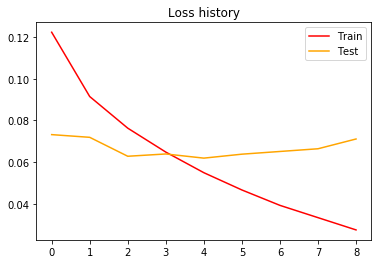

In [21]:
plt.plot(history[0],color='red',label='Train')
plt.plot(history[2],color='orange',label='Test')
plt.legend()
plt.plot()
plt.title("Loss history")

Text(0.5, 1.0, 'Training accuracy history')

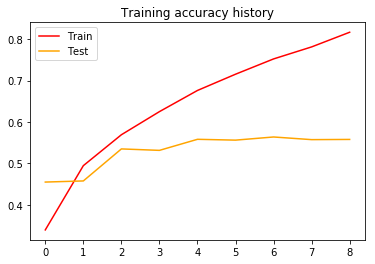

In [22]:
plt.plot(history[1],color='red',label='Train')
plt.plot(history[3],color='orange',label='Test')
plt.legend()
plt.plot()
plt.title("Training accuracy history")